### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.

Напомним, что на лекциях и семинарах мы разбирали некоторые подходы к оптимизации функционалов по параметрам. В частности, был рассмотрен градиентный спуск и различные подходы к его реализации — стохастический, метод импульса и другие. В качестве модели у нас будет выступать линейная регрессия.

В этом домашнем задании вам предстоит реализовать 4 различных вариации градиентного спуска, написать свою реализацию линейной регресии, сравнить методы градиентного спуска между собой на реальных данных и разобраться как подбирать гиперпараметры для этих методов.

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле  `utils.py`:

**Задание 1.1. (0.5 балла)** Полный градиентный спуск **GradientDescent**:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

**Задание 1.2. (1 балл)** Стохастический градиентный спуск **StochasticDescent**:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$ 

$\nabla_{w} q_{i_{k}}(w_{k}) \,$ - это оценка градиента по батчу объектов, выбранных случайно.

**Задание 1.3. (1 балл)** Метод Momentum **MomentumDescent**:

$$
    h_0 = 0, \\
    h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

**Задание 1.4. (1 балл)** Метод Adaptive gradient algorithm **Adagrad**:

$$
    G_0 = 0, \\
    G_{k + 1} = G_{k} + \left(\nabla_{w} Q(w_{k})\right) ^ 2, \\
    w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\varepsilon + G_{k + 1}}} \nabla_{w} Q(w_{k}).
$$


Во всех вышеназванных методах мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$
На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

Мы будем использовать функцию потерь MSE:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2
$$

Все вычисления должны быть векторизованы.

## Задание 2. Реализация линейной регресии (1.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `utils.py` - **LinearRegression**.

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы.
* Циклы средствами python допускаются только для итераций градиентного спуска.
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`.
    * Достижение максимального числа итераций `max_iter`.
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту).
* Инициализировать веса нужно нулевым вектором или из нормального $\mathcal{N}(0, 1)$ распределения (тогда нужно зафиксировать seed).

## Задание 3. Проверка кода (0 баллов)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np

from utils import (
    Adagrad,
    GradientDescent,
    MomentumDescent,
    StochasticDescent,
)
from utils import LinearRegression

In [3]:
from haversine import haversine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import os 
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator

In [4]:
num_objects = 100
dimension = 5

X = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

lambda_ = 1e-2
w0 = np.zeros(dimension)

max_iter = 10
tolerance = 0

In [5]:
s0_default: float = 1
p_default: float = 0.5

batch_size_default: int = 1

alpha_default: float = 0.1
eps_default: float = 1e-8

mu_default = 1e-2

tolerance_default: float = 1e-3
max_iter_default: int = 1000

In [6]:
class BaseDescent:
    """
    A base class and examples for all functions
    """

    def __init__(self):
        self.w = None

    def step(self, X: np.ndarray, y: np.ndarray, iteration: int) -> np.ndarray:
        """
        Descent step
        :param iteration: iteration number
        :param X: objects' features
        :param y: objects' targets
        :return: difference between weights
        """
        return self.update_weights(self.calc_gradient(X, y), iteration)

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Example for update_weights function
        :param iteration: iteration number
        :param gradient: gradient
        :return: weight difference: np.ndarray
        """
        if self.w == None:
            self.w = np.zeros(np.shape(y))
        
        for i in range(iteration):
            self.w -= gradient
        return self.w


    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Example for calc_gradient function
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        print((X@self.w-y)@X /(len(y)))
        return (X@self.w-y)@X /(len(y))

In [10]:
class GradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def __init__(self, w0: np.ndarray, lambda_: float, s0: float = s0_default, p: float = p_default):
        """
        :param w0: weight initialization
        :param lambda_: learning rate parameter (float)
        :param s0: learning rate parameter (float)
        :param p: learning rate parameter (float)
        """
        super().__init__()
        self.eta = lambda k: lambda_ * (s0 / (s0 + k)) ** p
        self.w = np.copy(w0)

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Changing weights with respect to gradient
        :param iteration: iteration number
        :param gradient: gradient
        :return: weight difference: np.ndarray
        """
        # TODO: implement updating weights function
        for i in range(iteration):
            step = self.eta * calc_gradient(X, y)
            self.w -= step
        return self

    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Getting objects, calculating gradient at point w
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        # TODO: implement calculating gradient function
        return (X@self.w-y)@X /(len(y))

In [11]:
# GradientDescent

descent = GradientDescent(lambda_ = lambda_, w0 = w0)

gradient1 = descent.calc_gradient(X, y)

assert gradient1.shape[0] == dimension, 'Gradient failed'

# diff = descent.step(X, y, 0)

# assert diff.shape[0] == dimension, 'Weights failed'

In [12]:
gradient1

array([-0.27609127, -0.25374032, -0.25545766, -0.24973055, -0.2815336 ])

In [53]:
class StochasticDescent(BaseDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, w0: np.ndarray, lambda_: float, s0: float = s0_default, p: float = p_default,
                 batch_size: int = batch_size_default):
        """
        :param w0: weight initialization
        :param lambda_: learning rate parameter (float)
        :param s0: learning rate parameter (float)
        :param p: learning rate parameter (float)
        :param batch_size: batch size (int)
        """
        super().__init__()
        self.eta = lambda k: lambda_ * (s0 / (s0 + k)) ** p
        self.batch_size = batch_size
        self.loss_history = []
        self.w = np.copy(w0)

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Changing weights with respect to gradient
        :param iteration: iteration number
        :param gradient: gradient estimate
        :return: weight difference: np.ndarray
        """
        # TODO: implement updating weights function
        for i in range(iteration):
            step = self.eta*self.calc_gradient(X[self.batch_size], y[self.batch_size]) 
            self.w -= step
            self.loss_history.append(mse(X@self.w, y))
        return self

    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Getting objects, calculating gradient at point w
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        # TODO: implement calculating gradient function
        return (X@self.w-y)@X /(len(y))

In [54]:
# StochasticDescent

descent = StochasticDescent(lambda_ = lambda_, w0 = w0)

gradient = descent.calc_gradient(X, y)

assert gradient.shape[0] == dimension, 'Gradient failed'

# diff = descent.step(X, y, 0)

# assert diff.shape[0] == dimension, 'Weights failed'

In [55]:
np.all(gradient1 == gradient)

True

In [16]:
class MomentumDescent(BaseDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, w0: np.ndarray, lambda_: float, alpha: float = alpha_default, s0: float = s0_default,
                 p: float = p_default):
        """
        :param w0: weight initialization
        :param lambda_: learning rate parameter (float)
        :param alpha: momentum coefficient
        :param s0: learning rate parameter (float)
        :param p: learning rate parameter (float)
        """
        super().__init__()
        self.eta = lambda k: lambda_ * (s0 / (s0 + k)) ** p
        self.alpha = alpha
        self.w = np.copy(w0)
        self.h = 0

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Changing weights with respect to gradient
        :param iteration: iteration number
        :param gradient: gradient estimate
        :return: weight difference: np.ndarray
        """
        for i in range(iteration):
            self.h = self.h*self.alpha + self.eta*self.calc_gradient(X, y)
            self.w -= self.h
        return self

    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Getting objects, calculating gradient at point w
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        # TODO: implement calculating gradient function
        return (X@self.w-y)@X /(len(y))

In [17]:
# MomentumDescent

descent = MomentumDescent(lambda_ = lambda_, w0 = w0)

gradient = descent.calc_gradient(X, y)

assert gradient.shape[0] == dimension, 'Gradient failed'

# diff = descent.step(X, y, 0)

# assert diff.shape[0] == dimension, 'Weights failed'

In [18]:
np.all(gradient1 == gradient)

True

In [38]:
class Adagrad(BaseDescent):
    """
    Adaptive gradient algorithm class
    """

    def __init__(self, w0: np.ndarray, lambda_: float, eps: float = eps_default, s0: float = s0_default,
                 p: float = p_default):
        """
        :param w0: weight initialization
        :param lambda_: learning rate parameter (float)
        :param eps: smoothing term (float)
        :param s0: learning rate parameter (float)
        :param p: learning rate parameter (float)
        """
        super().__init__()
        self.eta = lambda k: lambda_ * (s0 / (s0 + k)) ** p
        self.eps = eps
        self.w = np.copy(w0)
        self.g = 0

    def update_weights(self, gradient: np.ndarray, iteration: int) -> np.ndarray:
        """
        Changing weights with respect to gradient
        :param iteration: iteration number
        :param gradient: gradient estimate
        :return: weight difference: np.ndarray
        """
        # TODO: implement updating weights function
        self.g = np.zeros(np.shape(y))
        for i in range(iteration):
            k = np.random.randint(np.size(y))
            self.g = self.g + calc_gradient(X[k], y[k]) ** 2
            self.w = self.w - self.eta / ((self.g + self.eps)**0.5) * calc_gradient(X[k], y[k])
        return self        

    def calc_gradient(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Getting objects, calculating gradient at point w
        :param X: objects' features
        :param y: objects' targets
        :return: gradient: np.ndarray
        """
        # TODO: implement calculating gradient function
        return (X@self.w-y)@X /(len(y))

In [39]:
# Adagrad

descent = Adagrad(lambda_ = lambda_, w0 = w0)

gradient = descent.calc_gradient(X, y)

assert gradient.shape[0] == dimension, 'Gradient failed'

# diff = descent.step(X, y, 0)

# assert diff.shape[0] == dimension, 'Weights failed'

In [40]:
np.all(gradient1 == gradient)

True

In [103]:
class LinearReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=tolerance_default, max_iter=max_iter_default, w0=None, eta=1e-2,
                batch_size: int = batch_size_default):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w = w0 
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.batch_size = batch_size

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        X = sm.add_constant(X)
        
        if self.w==None:
            self.w=np.zeros(np.size(X,1))

        self.loss_history = []

        if self.gd_type == 'full':
            
            for i in range(self.max_iter):
                step=self.eta*self.calc_gradient(X,y) 
                w1=self.w.copy()
                self.w -= step
                self.loss_history.append(self.calc_loss(X, y))
                if np.linalg.norm(w1-self.w) < self.tolerance: 
                    print('break')
                    break
        
        else:
            
            for i in range(self.max_iter):
                step=self.eta*self.calc_gradient(X[self.batch_size],y[self.batch_size])  
                w1=self.w.copy()
                self.w = self.w-step
                self.loss_history.append(self.calc_loss(X, y))
                if np.linalg.norm(w1-self.w) < self.tolerance:
                    print('break')
                    break

        return self
    
    def predict(self, X):
        X = sm.add_constant(X)
        if self.w is None:
            raise Exception('Not trained yet')
        
        return X.dot(self.w)
    
    def calc_gradient(self, X, y):
        """
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        return X.T.dot(X.dot(self.w)-y)/np.size(y)

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """
        return mse(X@self.w, y)

In [104]:
import seaborn as sns

In [105]:
len(np.arange(max_iter_default)), len(GD_full.loss_history)

(1000, 1000)

break


<AxesSubplot:>

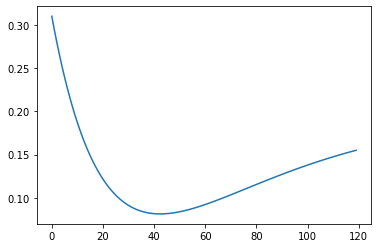

In [107]:
GD_full=LinearReg(eta=0.01, batch_size=1).fit(X, y)
GD_full

sns.lineplot(x=np.arange(len(GD_full.loss_history)), y=GD_full.loss_history)

In [42]:
# LinearRegression

regression = LinearRegression(
    descent = StochasticDescent(lambda_ = lambda_, w0 = w0, batch_size = 2),
    tolerance = tolerance,
    max_iter = max_iter
)

regression.fit(X, y)

assert len(regression.loss_history) == max_iter, 'Loss history failed'

prediction = regression.predict(X)

assert prediction.shape[0] == num_objects, 'Predict failed'

AttributeError: 'LinearRegression' object has no attribute 'eta'

Если ваше решение прошло все тесты локально, то теперь осталось протестировать его в Яндекс Контесте - **https://contest.yandex.ru/contest/19551**.

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **GradientDescent**: 
* **StochasticDescent**:
* **MomentumDescent**:
* **Adagrad**:
* **LinearRegression**:

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.
Для дальнейшей работы сделайте следующее:
* Проведите разумную предобработку данных.
* Замените целевую переменную на её логарифм.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 3:1:1.

In [ ]:
# YOUR CODE:

## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

* **Задание 5.1. (1.5 балла)** Подберите по валидационной выборке наилучшую длину $\lambda$ шага для каждого метода. Для этого можно сделать перебор по логарифмической сетке, так как нас интересует скорее порядок величины, нежели её точное значение. Сравните качество методов по метрикам MSE и R^2 на обучающей и тестовой выборках, сравните количество итераций до сходимости. Все параметры кроме $\lambda$ стоит выставить равным значениям по умолчанию.

* **Задание 5.2. (0.5 балла)** Постройте график зависимости значения функции ошибки от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты. Сравните методы между собой.

In [ ]:
w0 = np.zeros(x_train.shape[1])

# YOUR CODE:

## Задание 6. Сходимость стохастического градиентного спуска в зависимости от размера батча (1 балл)

В этом задании вам предстоит исследовать влияние размера батча на работу стохастического градиентного спуска. 

* Сделайте по несколько запусков (например, k) стохастического градиентного спуска на обучающей выборке для каждого размера батча из списка. Замерьте время и количество итераций до сходимости. Посчитайте среднее и дисперсию этих значений для каждого размера батча.
* Постройте график зависимости количества шагов до сходимости от размера батча.
* Постройте график зависимости времени до сходимости от размера батча.

Посмотрите на получившиеся результаты. Какие выводы можно сделать про подбор размера батча для стохастического градиентного спуска?

In [ ]:
batch_sizes = np.arange(5, 500, 10)

# YOUR CODE:

## Задание 7. Регуляризация (1 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. (Напомним, регуляризация - это добавка к функции потерь, которая штрафует за норму весов). Мы будем использовать l2 регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

Допишите классы **GradientDescentReg**, **StochasticDescentReg**, **MomentumDescentReg**, **AdagradReg** в файле `utils.py`. Мы будем использовать тот же самый класс для линейной регрессии, так как для сравнения методов с регуляризацией и без неё нам нужна только MSE часть функции потерь.

Найдите по валидационной выборке лучшие параметры обучения с регуляризацией. Сравните для каждого метода результаты на тестовой выборке по метрикам MSE и R^2 с регуляризацией и без регуляризации. Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации.

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Чем вы можете объяснить это?

In [ ]:
%autoreload 2

from utils import (
    AdagradReg,
    GradientDescentReg,
    MomentumDescentReg,
    StochasticDescentReg,
)

# YOUR CODE:

## Задание 8. Бонус — Реализация метода SAG (2 балла)

В качестве бонуса вам будет следующее задание - напишите собственную реализацию стохастического градиентного спуска по методу SAG в файле `utils.py`. Подробнее прочитать про SAG можно [здесь](https://arxiv.org/pdf/1309.2388.pdf).

Сравните свою реализацию метода SAG с обычным полным градиентным спуском на наших данных. Проведите сравнение аналогично заданию 5. Что вы можете сказать про сходимость этого метода?

In [ ]:
# YOUR CODE:

Вставьте картинку или видео, описывающие ваш опыт выполнения этого задания.